In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from mosqlient import get_predictions
from mosqlient.models.score import Scorer

import seaborn as sns
import dataframe_image as dfi
from itertools import product

In this notebook the scores: CRPS, Log Score, and interval score are applied in a tree week center window:

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/dengue_uf.csv.gz')
data.date = pd.to_datetime(data.date)
data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


In [4]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)

    data_ = data_.rename(columns = {'date':'dates'})
    
    return data_

Defining the data around the peak:

In [5]:
data_23 = data.loc[(data.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d'))] 
data_24 = data.loc[(data.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d'))] 

In [6]:
peak_dates = {'AM':{2023: {}, 2024: {}}, 'CE': {2023: {}, 2024: {}}, 'GO':{2023: {}, 2024: {}}, 'PR':{2023: {}, 2024: {}}, 'MG':{2023: {}, 2024: {}}}

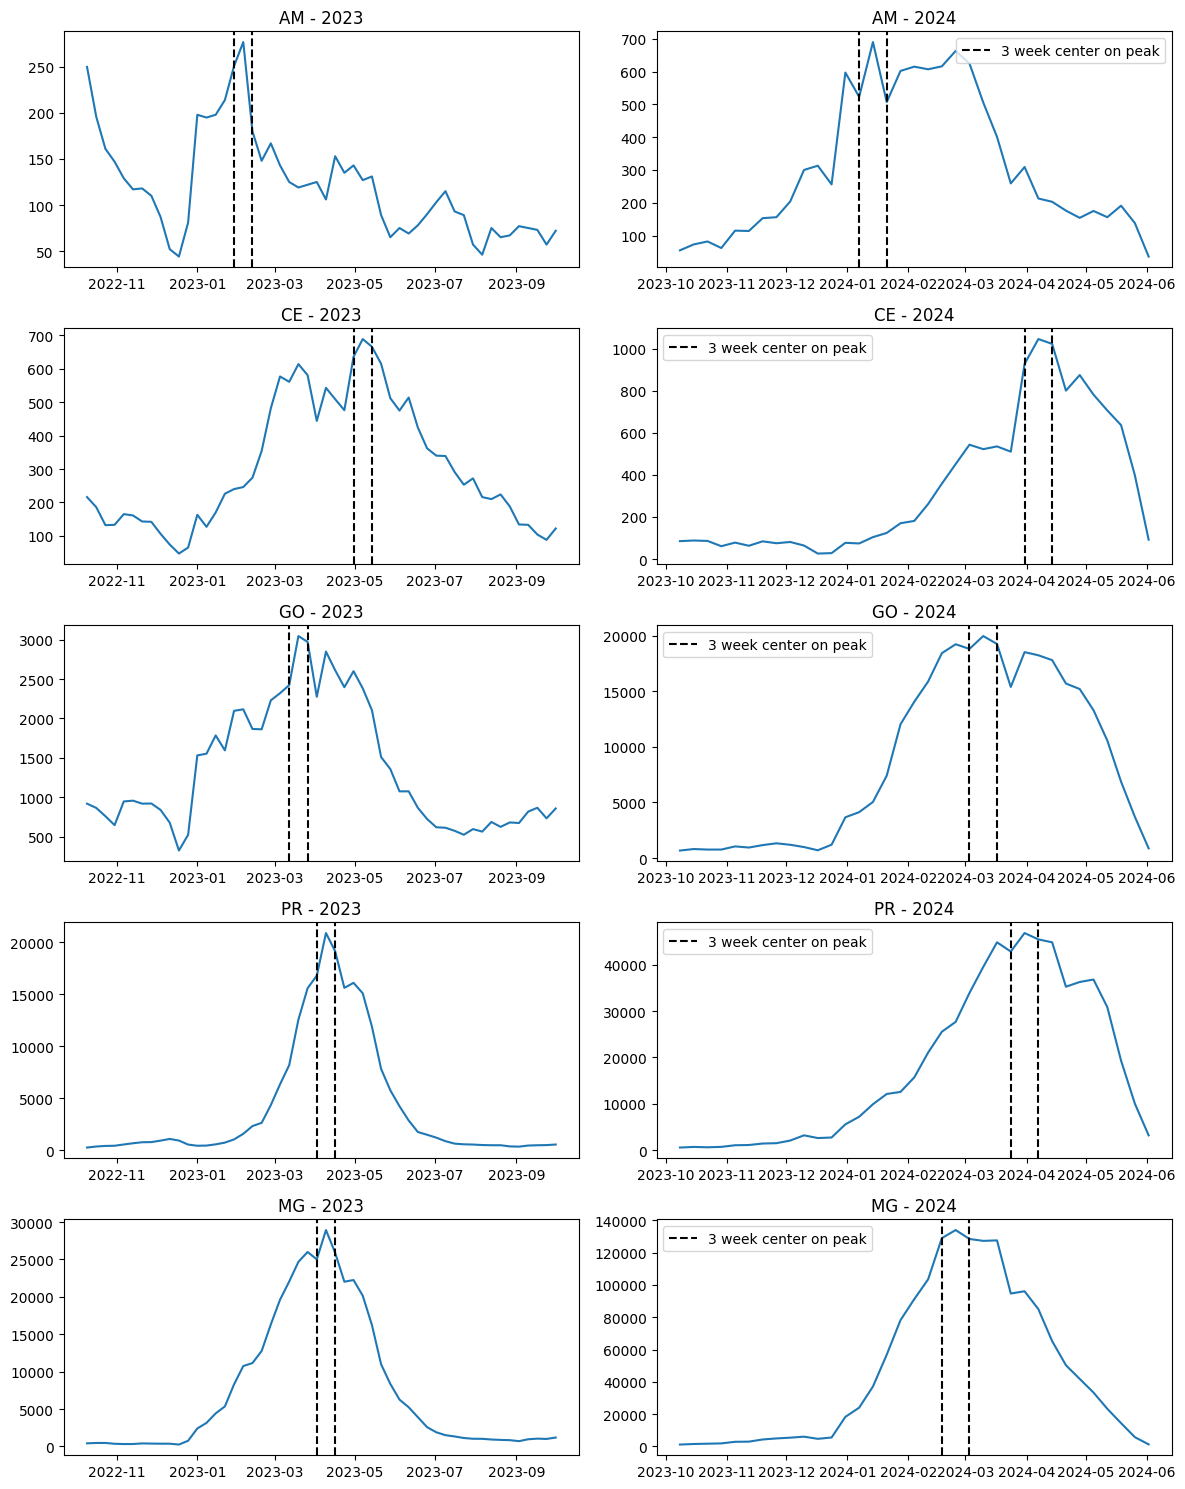

In [7]:

fig, ax = plt.subplots(5,2, figsize = (12, 15))

axs = ax.ravel()

i=0 
for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    
    df_23 = get_cases(data_23, state)
    
    axs[i].plot(df_23.dates, df_23.casos)

    axs[i].set_title(f'{state} - 2023')

    peak_date = pd.to_datetime(df_23.loc[df_23.casos == df_23['casos'].max()].dates.values[0])

    pd1 = peak_date - pd.Timedelta(weeks=1)

    pd2 = peak_date + pd.Timedelta(weeks=1)

    axs[i].axvline(pd1, color = 'black', ls = '--')

    axs[i].axvline(pd2, color = 'black', ls = '--')

    peak_dates[state][2023]['start_date'] = pd1
    peak_dates[state][2023]['end_date'] = pd2

    df_24 = get_cases(data_24, state)
    
    axs[i+1].plot(df_24.dates, df_24.casos)

    axs[i+1].set_title(f'{state} - 2024')

    peak_date = pd.to_datetime(df_24.loc[df_24.casos == df_24['casos'].max()].dates.values[0])

    pd1 = peak_date - pd.Timedelta(weeks=1)

    pd2 = peak_date + pd.Timedelta(weeks=1)

    peak_dates[state][2024]['start_date'] = pd1
    peak_dates[state][2024]['end_date'] = pd2

    axs[i+1].axvline(pd1, color = 'black', ls = '--')

    axs[i+1].axvline(pd2, color = 'black', ls = '--', label = '3 week center on peak')

    axs[i+1].legend()

    i = i+2

plt.tight_layout()

In [8]:
peak_dates

{'AM': {2023: {'start_date': Timestamp('2023-01-29 00:00:00'),
   'end_date': Timestamp('2023-02-12 00:00:00')},
  2024: {'start_date': Timestamp('2024-01-07 00:00:00'),
   'end_date': Timestamp('2024-01-21 00:00:00')}},
 'CE': {2023: {'start_date': Timestamp('2023-04-30 00:00:00'),
   'end_date': Timestamp('2023-05-14 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-31 00:00:00'),
   'end_date': Timestamp('2024-04-14 00:00:00')}},
 'GO': {2023: {'start_date': Timestamp('2023-03-12 00:00:00'),
   'end_date': Timestamp('2023-03-26 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-03 00:00:00'),
   'end_date': Timestamp('2024-03-17 00:00:00')}},
 'PR': {2023: {'start_date': Timestamp('2023-04-02 00:00:00'),
   'end_date': Timestamp('2023-04-16 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-24 00:00:00'),
   'end_date': Timestamp('2024-04-07 00:00:00')}},
 'MG': {2023: {'start_date': Timestamp('2023-04-02 00:00:00'),
   'end_date': Timestamp('2023-04-16 00:00:00')},
  2

Teams and model_id na plataforma: 


| Team                     | Model id |
| ------------------------ | ------------- |
| D-fense                  | ------------  |
| Dobby Data               | 21            |
| GeoHealth                | 25,26         |
| Global Health Resilience | 22            |
| BNN                      | 30            |
| Ki-Dengu Peppa           | 27, 28        |
| DS_OKSTATE               | 29            |
 


The cell below fetch the predictions from the API and compute the scores for the 52 weeks interval saved on the `df_score_end_52` dataframe and for the 26 weeks interval saved on the `df_score_end_26` dataframe. 

In [9]:
def get_preds(model_id):

    list_of_preds = []
    
    if model_id == 27:

        for p_id in np.arange(250,260):

            print(p_id)
            
            list_of_preds.append(get_predictions(id = int(p_id)))

    elif model_id == 28:

        for p_id in np.arange(260,270):
            
            list_of_preds.append(get_predictions(id = int(p_id)))

    else: 
        list_of_preds = get_predictions(model_id = model_id)


    return list_of_preds 



In [10]:
%%time 
df_score_end_peak  = pd.DataFrame()

for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_preds(model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            preds_id = list_of_preds[idx].id
            df_true = get_cases(data, state)
    
            score = Scorer(df_true = df_true, ids = [preds_id], confidence_level=0.9)

            year = pd.to_datetime(df.dates).dt.year.max()

            score.set_date_range(start_date = peak_dates[state][year]['start_date'].strftime('%Y-%m-%d'),
                                 end_date = peak_dates[state][year]['end_date'].strftime('%Y-%m-%d'))
            
            df_score_ = score.summary
            df_score_['state'] = state
            df_score_['year'] = year
            if model_id == 26:
                df_score_['model_id'] = 25
            else:
                df_score_['model_id'] = model_id
           
            df_score_end_peak = pd.concat([df_score_end_peak, df_score_])           

250
251
252
253
254
255
256
257
258
259
CPU times: user 3.39 s, sys: 467 ms, total: 3.86 s
Wall time: 2min 9s


In [11]:
df_score_end_peak

,mae,mse,crps,log_score,interval_score,state,year,model_id
id,,,,,,,,
224,604.489846,3.691761e+05,537.090972,-19.190991,8.470749e+03,CE,2023,21
225,182.252439,4.430086e+04,127.932377,-6.891254,1.461322e+03,CE,2024,21
226,10564.449501,1.128782e+08,10333.476227,-100.000000,1.997084e+05,PR,2023,21
227,25010.924684,6.298968e+08,24606.157189,-100.000000,4.774537e+05,PR,2024,21
228,4201.604316,1.946653e+07,3769.311937,-24.229922,5.965924e+04,MG,2023,21
...,...,...,...,...,...,...,...,...
215,392.833333,1.611458e+05,322.742962,-10.977502,2.383467e+03,AM,2024,30
216,466.166667,2.198964e+05,346.381942,-8.060047,3.836517e+03,CE,2024,30
217,15140.500000,2.294463e+08,14105.077110,-42.556340,2.251577e+05,GO,2024,30


Checking the shape od the data:

In [12]:
df_score_end_peak.shape

(70, 8)

Checking for null values:

In [13]:
df_score_end_peak.isnull().sum()

mae               0
mse               0
crps              0
log_score         0
interval_score    0
state             0
year              0
model_id          0
dtype: int64

In [14]:
df_score_end_peak.model_id.value_counts()

model_id
21    10
22    10
25    10
27    10
28    10
29    10
30    10
Name: count, dtype: int64

## Analysing the scores

Functions to rank the models:

In [15]:
def compute_the_rank_by_scores(df_peak): 
    '''
    Rank the models by each of the scores S1,..., S3 proposed. 
    '''
    
    S1 = df_peak[['crps', 'model_id']].copy()
    S1['rank'] = df_peak['crps'].rank(method='dense', ascending=True)
    S1['score'] = 'S1'

    S2 = df_peak[['log_score', 'model_id']].copy()
    S2['rank'] = df_peak['log_score'].rank(method='dense', ascending=False)
    S2['score'] = 'S2'

    S3 = df_peak[['interval_score', 'model_id']].copy()
    S3['rank'] = df_peak['interval_score'].rank(method='dense', ascending=True)
    S3['score'] = 'S3'

    S = pd.concat([S1, S2, S3]).reset_index(drop = True)

    S = pd.pivot_table(S, values = 'rank', index='model_id',
                      columns = ['score'])

    S.columns = 'rank_' + S.columns 

    return S

def compute_the_final_rank(S):
    '''
    Get the final rank of the models based on the output of the compute_the_rank_by_scores function. 
    '''
    v_r_end = []
    for model_id in S.index: 
    
        rank_final = ((1/S.loc[model_id]['rank_S1']) +
                     (1/S.loc[model_id]['rank_S2']) +
                     (1/S.loc[model_id]['rank_S3']) )
    
        v_r_end.append(rank_final)
    
    df_rank = pd.DataFrame()
    
    df_rank['model_id'] = S.index
    df_rank['rank_values'] = v_r_end

    df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 
    df_rank['state'] = state
    df_rank['year'] = year

    df_rank = df_rank.set_index('model_id')

    df_rank = df_rank.rename(columns = {'rank':'composite_rank'})

    df_rank = S.merge(df_rank[['composite_rank', 'state', 'year']], left_index = True, right_index = True)

    for c in ['rank_S1', 'rank_S2', 'rank_S3', 'composite_rank']:

        df_rank[c] = df_rank[c].astype(int)

    return df_rank.sort_values(by ='composite_rank')


def color_and_save_table(df_rank, filename, subset = ['rank_S1', 'rank_S2', 'rank_S3', 
                                             'rank_S4', 'rank_S5', 'rank_S6', 'composite_rank']):

    cm = sns.color_palette('light:b_r', as_cmap=True)

    rename_models = {30: 'BB-M', 21: 'Dobby data', 25: 'GeoHealth', 
                22: 'Global Health Resilience', 29: 'DS_OKSTATE',
                27: 'Ki-Dengu Peppa model 1', 
                28: 'Ki-Dengu Peppa model 2'}

    df_rank = df_rank.rename(index=rename_models)

    df_rank.index.name = 'Model'

    df_rank = df_rank.style.background_gradient(subset=subset, cmap=cm)

    dfi.export(df_rank, f'./figures/{filename}.png')

    return df_rank
    

Get the final rank for each state and year and create a figure of the table colored according to the rank value: 

In [16]:
import seaborn as sns
import dataframe_image as dfi
from itertools import product 

In [17]:
cm = sns.color_palette('light:b_r', as_cmap=True)

In [18]:
%%time 
for state, year in product(['AM','CE','GO','PR','MG'], [2023, 2024]):
    df_peak_ = df_score_end_peak.loc[(df_score_end_peak.state == state) & (df_score_end_peak.year == year)]

    S_end = compute_the_rank_by_scores(df_peak_)

    R_end = compute_the_final_rank(S_end)
    R_end.to_csv(f'tables/ranking_peak_{state}_{year}.csv')


    color_and_save_table(R_end, filename = f'ranking_peak_{state}_{year}',
                         subset = ['rank_S1', 'rank_S2', 'rank_S3', 'composite_rank'])
    

CPU times: user 523 ms, sys: 129 ms, total: 652 ms
Wall time: 5.7 s


Get the final rank for each state based on the rank of each year:

In [19]:
for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    df_r_2023 = pd.read_csv(f'tables/ranking_peak_{state}_2023.csv', index_col = 'model_id')
    
    df_r_2024 = pd.read_csv(f'tables/ranking_peak_{state}_2024.csv', index_col = 'model_id')
    
    v_r_end = []
    for model_id in df_r_2023.index: 
        
            rank_final = ((1/df_r_2023.loc[model_id]['composite_rank']) +
                         (1/df_r_2024.loc[model_id]['composite_rank']))
        
            v_r_end.append(rank_final)
        
    df_rank = pd.DataFrame()
        
    df_rank['model_id'] = df_r_2023.index
    df_rank['rank_values'] = v_r_end
    
    df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 
    df_rank['state'] = state
   
    df_rank.to_csv(f'tables/ranking_peak_{state}.csv', index = False)

Get the global rank based on the rank of each mandatory state: 

In [20]:
def get_global_rank(year=None): 
    list_of_dfs = [] 

    for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 
        if year == None:
            col_name = 'rank'
            df_rank_ = pd.read_csv(f'tables/ranking_peak_{state}.csv', index_col = 'model_id', usecols = ['model_id', col_name])
        else: 
            col_name = 'composite_rank'
            df_rank_ = pd.read_csv(f'tables/ranking_peak_{state}_{year}.csv', index_col = 'model_id', usecols = ['model_id', col_name])
            
        df_rank_ = df_rank_.rename(columns = {col_name: f'rank_{state}'} )
    
        list_of_dfs.append(df_rank_)
        
    df_rank_states = pd.concat(list_of_dfs,axis =1)

    v_r_end = []

    for model_id in df_rank_states.index: 
    
        rank_final = (
                             (1/df_rank_states.loc[model_id]['rank_AM']) +
                             (1/df_rank_states.loc[model_id]['rank_CE']) + 
                             (1/df_rank_states.loc[model_id]['rank_GO']) + 
                             (1/df_rank_states.loc[model_id]['rank_MG']) + 
                             (1/df_rank_states.loc[model_id]['rank_PR']))
        v_r_end.append(rank_final)
        
    df_rank = pd.DataFrame()
        
    df_rank['model_id'] = df_rank_states.index
    df_rank['rank_values'] = v_r_end
        
    df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 
    
    df_rank.set_index('model_id',inplace = True)
    
    df_rank = df_rank.rename(columns = {'rank': 'global_rank'})
    
    df_rank = df_rank_states.merge(df_rank['global_rank'], left_index = True, right_index = True)
    
    df_rank = df_rank.sort_values(by = 'global_rank')
    
    df_rank = df_rank.astype(int)

    if year != None:
        df_rank['year'] = year

    return df_rank 

In [21]:
df_rank = get_global_rank(year=None)

df_rank_cor = color_and_save_table(df_rank, filename = f'ranking_peak_global',
                         subset = ['rank_AM', 'rank_CE', 'rank_GO', 
                                             'rank_PR', 'rank_MG', 'global_rank'])

df_rank_cor

,rank_AM,rank_CE,rank_GO,rank_PR,rank_MG,global_rank
Model,,,,,,
Dobby data,4,1,1,4,2,1
Global Health Resilience,5,2,1,1,5,2
Ki-Dengu Peppa model 1,3,4,2,2,1,3
GeoHealth,1,3,3,2,3,4
Ki-Dengu Peppa model 2,7,5,4,3,1,5
BB-M,6,1,4,5,4,6
DS_OKSTATE,2,6,5,6,6,7


In [22]:
year = 2023
df_rank = get_global_rank(year=year)

df_rank_cor = color_and_save_table(df_rank, filename = f'ranking_peak_global_{year}',
                         subset = ['rank_AM', 'rank_CE', 'rank_GO', 
                                             'rank_PR', 'rank_MG', 'global_rank'])

df_rank_cor

,rank_AM,rank_CE,rank_GO,rank_PR,rank_MG,global_rank,year
Model,,,,,,,
Dobby data,2,2,1,6,2,1,2023
Ki-Dengu Peppa model 1,6,3,2,2,1,2,2023
BB-M,3,1,3,5,3,3,2023
Global Health Resilience,4,3,4,1,6,4,2023
GeoHealth,1,5,7,4,4,5,2023
Ki-Dengu Peppa model 2,5,4,6,3,5,6,2023
DS_OKSTATE,7,6,5,7,7,7,2023


In [23]:
year = 2024
df_rank = get_global_rank(year=year)

df_rank_cor = color_and_save_table(df_rank, filename = f'ranking_peak_global_{year}',
                         subset = ['rank_AM', 'rank_CE', 'rank_GO', 
                                             'rank_PR', 'rank_MG', 'global_rank'])

df_rank_cor

,rank_AM,rank_CE,rank_GO,rank_PR,rank_MG,global_rank,year
Model,,,,,,,
Global Health Resilience,3,4,1,1,4,1,2024
GeoHealth,4,3,2,2,2,2,2024
Ki-Dengu Peppa model 2,5,5,3,3,1,3,2024
Dobby data,7,1,4,4,3,4,2024
DS_OKSTATE,1,7,7,6,7,5,2024
Ki-Dengu Peppa model 1,2,6,5,4,5,6,2024
BB-M,6,2,6,5,6,7,2024
